In [ ]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.23.5
!pip install pmdarima

🚀 Bắt đầu dự báo CDS Spread bằng ARIMA...
✅ Dữ liệu sau xử lý: 3525 dòng
             Open  CDS_Spread
Date                         
2010-01-04  60.04       60.04
2010-01-05  58.05       58.05
2010-01-06  55.54       55.54
2010-01-07  53.57       53.57
2010-01-08  52.58       52.58

🔍 Tìm mô hình ARIMA tối ưu...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40463.840, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40416.683, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40429.946, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40461.841, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40241.034, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40215.873, Time=0.50 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=40029.109, Time=0.74 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=39912.471, Time=1.01 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=39831.840, Time=3.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AI

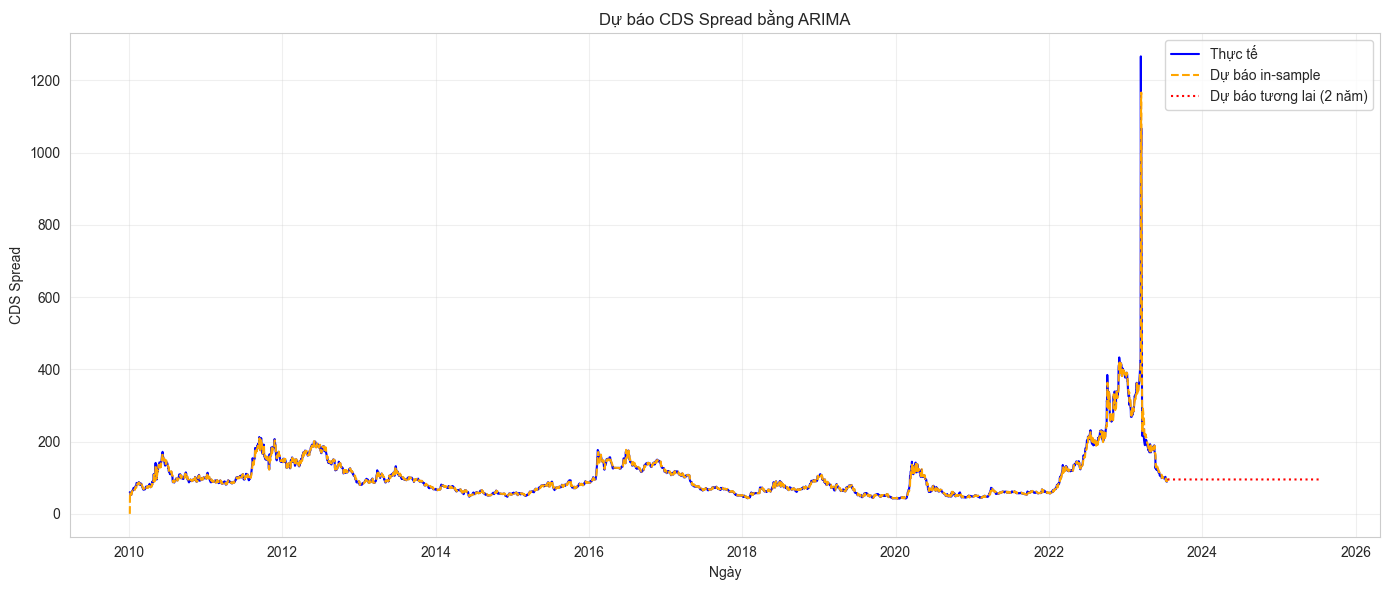


💾 Đã lưu kết quả:
  - cds_forecast_2_years.csv
  - model_metrics.csv


In [4]:
# %% 1. Import thư viện
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

print("🚀 Bắt đầu dự báo CDS Spread bằng ARIMA...")

# %% 2. Đọc dữ liệu
file_path = r"C:\Users\user\Downloads\CSGN5YEUAM=R Overview (2).csv"

# Thử đọc với encoding utf-8 hoặc latin-1 nếu lỗi
try:
    df = pd.read_csv(file_path, parse_dates=['Date'])
except Exception as e:
    print("Lỗi khi đọc file, thử lại với encoding...")
    df = pd.read_csv(file_path, parse_dates=['Date'], encoding='latin-1')

# %% 3. Sắp xếp và đặt index
df = df.sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)

# %% 4. Tiền xử lý cột Open → CDS_Spread
# Loại bỏ hàng có giá trị trống
df = df.dropna(subset=['Open'])

# Loại bỏ dòng có giá trị 'null', 'NaN', hoặc chuỗi không hợp lệ
df = df[df['Open'].astype(str).str.strip() != 'null']
df = df[df['Open'].astype(str).str.strip() != 'NaN']

# Xử lý dấu phẩy (nếu có) và chuyển sang float
df['CDS_Spread'] = df['Open'].astype(str).str.replace(',', '', regex=False).astype(float)

# Kiểm tra dữ liệu sau xử lý
print(f"✅ Dữ liệu sau xử lý: {len(df)} dòng")
print(df[['Open', 'CDS_Spread']].head())

# Chuẩn bị chuỗi thời gian
y = df['CDS_Spread']

# Kiểm tra xem có khoảng trống thời gian không?
# Nếu có, nên interpolate hoặc resample
y = y.asfreq('D')  # Giả định tần suất ngày
y = y.interpolate(method='time')  # Điền khoảng trống theo thời gian

# %% 5. Tìm mô hình ARIMA tối ưu
print("\n🔍 Tìm mô hình ARIMA tối ưu...")
model = auto_arima(
    y,
    start_p=0, start_q=0,  # p, q bắt đầu từ 1
    max_p=5, max_q=5,
    d=None,  # auto chọn d
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    trace=True,  # in ra quá trình tìm kiếm
    error_action='ignore',  # bỏ qua mô hình lỗi
    n_fits=100 # giới hạn số mô hình thử
)

print("🎯 Cấu hình ARIMA tốt nhất:", model.order)

# %% 6. Huấn luyện mô hình
print("\n🧮 Đang huấn luyện mô hình...")
model.fit(y)

# %% 7. Dự báo in-sample
fitted_values = model.predict_in_sample()

# Kiểm tra độ dài: fitted_values có thể ngắn hơn y nếu dùng differencing
if len(fitted_values) < len(y):
    # Cắt phần đầu của y để khớp
    y_aligned = y[len(y) - len(fitted_values):]
    fitted_aligned = fitted_values
else:
    y_aligned = y
    fitted_aligned = fitted_values[:len(y)]

# %% 8. Tính MAE và MAPE
mae = mean_absolute_error(y_aligned, fitted_aligned)
mape = (np.abs(y_aligned - fitted_aligned) / y_aligned).mean() * 100

print(f"\n📊 Đánh giá mô hình:")
print(f"MAE: {mae:.6f}")
print(f"MAPE: {mape:.4f}%")

# Lưu chỉ số đánh giá
metrics = pd.DataFrame({'MAE': [mae], 'MAPE (%)': [mape]})

# %% 9. Dự báo tương lai
n_future = 365 * 2  # 2 năm
future_forecast = model.predict(n_periods=n_future)

# Tạo index cho tương lai
future_index = pd.date_range(
    start=y.index[-1] + pd.Timedelta(days=1),
    periods=n_future,
    freq='D'
)

# Chuyển thành Series
future_forecast_series = pd.Series(future_forecast, index=future_index)

# %% 10. Vẽ đồ thị
plt.figure(figsize=(14, 6))
plt.plot(y.index, y, label='Thực tế', color='blue')
plt.plot(y_aligned.index, fitted_aligned, label='Dự báo in-sample', linestyle='--', color='orange')
plt.plot(future_index, future_forecast_series, label='Dự báo tương lai (2 năm)', linestyle=':', color='red')

plt.xlabel('Ngày')
plt.ylabel('CDS Spread')
plt.title('Dự báo CDS Spread bằng ARIMA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% 11. Xuất kết quả
output_forecast = pd.DataFrame({
    'Date': future_index,
    'CDS_Spread_Forecast': future_forecast_series
}).set_index('Date')

output_forecast.to_csv('cds_forecast_2_years.csv')
metrics.to_csv('model_metrics.csv')

print("\n💾 Đã lưu kết quả:")
print("  - cds_forecast_2_years.csv")
print("  - model_metrics.csv")

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# Dữ liệu mẫu (giống bạn gửi)
data = {
    'Quarter': [
        'Q1 2016','Q2 2016','Q3 2016','Q4 2016','Q1 2017','Q2 2017','Q3 2017','Q4 2017',
        'Q1 2018','Q2 2018','Q3 2018','Q4 2018','Q1 2019','Q2 2019','Q3 2019','Q4 2019',
        'Q1 2020','Q2 2020','Q3 2020','Q4 2020','Q1 2021','Q2 2021','Q3 2021','Q4 2021',
        'Q1 2022','Q2 2022','Q3 2022','Q4 2022'
    ],
    'LCR': [151,172,163,202,205,165,181,185,208,226,202,184,191,193,189,198,182,196,190,190,205,216,221,203,196,191,154,144],
    'Net_Income': [-302,170,41,-2619,596,303,244,-2126,694,647,424,292,749,937,881,852,1314,1162,546,-353,-252,253,434,-2007,-273,-1593,-4034,-1393],
    'Cost_Income': [84.5,82.3,79.8,86.3,78.4,77.8,80.5,88.1,74.1,74.1,79.4,80.2,78.8,76.2,77.2,78.0,69.4,70.2,82.7,99.0,52.0,84.6,84.1,135.1,112.2,130.4,108.4,141.6],
    'ROE': [-2.6,1.5,0.4,-23.8,5.7,3.0,2.2,-19.5,6.7,6.1,4.0,2.7,6.9,8.5,8.0,7.6,11.7,9.8,4.8,-3.2,-2.3,2.3,4.0,-18.0,-2.4,-8.2,-35.5,-12.5],
    'CET1': [13.6,14.2,14.1,13.5,12.7,14.2,14.0,13.5,12.9,12.8,12.9,12.6,12.6,12.5,12.4,12.7,12.1,12.5,13.0,12.9,12.2,13.7,14.4,14.4,13.8,13.5,12.6,14.1]
}

df = pd.DataFrame(data)
df.set_index('Quarter', inplace=True)

# Các biến độc lập
independent_vars = ['LCR','Cost_Income','ROE','CET1']

# Hàm signed log transform
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Áp dụng signed log transform cho tất cả các cột
df_log = df.apply(signed_log)

# Kiểm định Granger causality
for var in independent_vars:
    print(f"\n🔹 Granger causality test (signed log): {var} → Net_Income")
    grangercausalitytests(df_log[['Net_Income', var]], maxlag=2, verbose=True)



🔹 Granger causality test (signed log): LCR → Net_Income

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2184  , p=0.6445  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=0.2457  , p=0.6201  , df=1
likelihood ratio test: chi2=0.2446  , p=0.6209  , df=1
parameter F test:         F=0.2184  , p=0.6445  , df_denom=24, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8694  , p=0.4337  , df_denom=21, df_num=2
ssr based chi2 test:   chi2=2.1529  , p=0.3408  , df=2
likelihood ratio test: chi2=2.0684  , p=0.3555  , df=2
parameter F test:         F=0.8694  , p=0.4337  , df_denom=21, df_num=2

🔹 Granger causality test (signed log): Cost_Income → Net_Income

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9836  , p=0.0042  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=11.2315 , p=0.0008  , df=1
likelihood ratio test: chi2=9.3912  , p=0.0022  , df=1
parameter F test:         F=9.9836  , p=0.0042  , 

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller

# --- 1. Dữ liệu ---
data = {
    'Quarter': [
        'Q1 2016', 'Q2 2016', 'Q3 2016', 'Q4 2016',
        'Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017',
        'Q1 2018', 'Q2 2018', 'Q3 2018', 'Q4 2018',
        'Q1 2019', 'Q2 2019', 'Q3 2019', 'Q4 2019',
        'Q1 2020', 'Q2 2020', 'Q3 2020', 'Q4 2020',
        'Q1 2021', 'Q2 2021', 'Q3 2021', 'Q4 2021',
        'Q1 2022', 'Q2 2022', 'Q3 2022', 'Q4 2022'
    ],
    'Profit': [-302,170,41,-2619,596,303,244,-2126,694,647,424,292,
               749,937,881,852,1314,1162,546,-353,-252,253,434,-2007,
               -273,-1593,-4034,-1393],
    'Cost_Income': [84.5,82.3,79.8,86.3,78.4,77.8,80.5,88.1,74.1,74.1,79.4,80.2,
                    78.8,76.2,77.2,78.0,69.4,70.2,82.7,99.0,52.0,84.6,84.1,135.1,
                    112.2,130.4,108.4,141.6],
    'CET1': [13.6,14.2,14.1,13.5,12.7,14.2,14.0,13.5,12.9,12.8,12.9,12.6,
             12.6,12.5,12.4,12.7,12.1,12.5,13.0,12.9,12.2,13.7,14.4,14.4,
             13.8,13.5,12.6,14.1]
}

df = pd.DataFrame(data)
df.set_index('Quarter', inplace=True)

# --- 2. Log biến ---
df['ln_Profit'] = np.sign(df['Profit']) * np.log(np.abs(df['Profit']) + 1)
df['ln_CET1'] = np.log(df['CET1'])
df['ln_Cost_Income'] = np.log(df['Cost_Income'])

# --- 3. Hàm kiểm định Engle-Granger ---
def engle_granger_test(Y, X, alpha=0.05):
    """
    Y: chuỗi phụ thuộc (1D array)
    X: chuỗi độc lập (DataFrame hoặc 2D array)
    alpha: mức ý nghĩa
    """
    X_const = add_constant(X)
    model = OLS(Y, X_const).fit()
    residuals = model.resid

    # ADF test trên phần dư
    adf_result = adfuller(residuals)
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    conclusion = "Cointegrated ✅" if p_value < alpha else "Not cointegrated ❌"

    return {
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Conclusion': conclusion
    }

# --- 4. Thực hiện kiểm định ---
X_vars = ['ln_CET1','ln_Cost_Income']
print(df[X_vars])
result = engle_granger_test(df['ln_Profit'], df[X_vars])

print("📊 Kết quả kiểm định Engle-Granger")
print(f"ADF Statistic: {result['ADF Statistic']:.4f}")
print(f"p-value: {result['p-value']:.4f}")
print(f"Kết luận: {result['Conclusion']}")


          ln_CET1  ln_Cost_Income
Quarter                          
Q1 2016  2.610070        4.436752
Q2 2016  2.653242        4.410371
Q3 2016  2.646175        4.379524
Q4 2016  2.602690        4.457830
Q1 2017  2.541602        4.361824
Q2 2017  2.653242        4.354141
Q3 2017  2.639057        4.388257
Q4 2017  2.602690        4.478473
Q1 2018  2.557227        4.305416
Q2 2018  2.549445        4.305416
Q3 2018  2.557227        4.374498
Q4 2018  2.533697        4.384524
Q1 2019  2.533697        4.366913
Q2 2019  2.525729        4.333361
Q3 2019  2.517696        4.346399
Q4 2019  2.541602        4.356709
Q1 2020  2.493205        4.239887
Q2 2020  2.525729        4.251348
Q3 2020  2.564949        4.415220
Q4 2020  2.557227        4.595120
Q1 2021  2.501436        3.951244
Q2 2021  2.617396        4.437934
Q3 2021  2.667228        4.432007
Q4 2021  2.667228        4.906015
Q1 2022  2.624669        4.720283
Q2 2022  2.602690        4.870607
Q3 2022  2.533697        4.685828
Q4 2022  2.646

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# Dữ liệu mẫu (giống bạn gửi)
data = {
    'Quarter': [
        'Q1 2016','Q2 2016','Q3 2016','Q4 2016','Q1 2017','Q2 2017','Q3 2017','Q4 2017',
        'Q1 2018','Q2 2018','Q3 2018','Q4 2018','Q1 2019','Q2 2019','Q3 2019','Q4 2019',
        'Q1 2020','Q2 2020','Q3 2020','Q4 2020','Q1 2021','Q2 2021','Q3 2021','Q4 2021',
        'Q1 2022','Q2 2022','Q3 2022','Q4 2022'
    ],
    'LCR': [151,172,163,202,205,165,181,185,208,226,202,184,191,193,189,198,182,196,190,190,205,216,221,203,196,191,154,144],
    'Net_Income': [-302,170,41,-2619,596,303,244,-2126,694,647,424,292,749,937,881,852,1314,1162,546,-353,-252,253,434,-2007,-273,-1593,-4034,-1393],
    'Cost_Income': [84.5,82.3,79.8,86.3,78.4,77.8,80.5,88.1,74.1,74.1,79.4,80.2,78.8,76.2,77.2,78.0,69.4,70.2,82.7,99.0,52.0,84.6,84.1,135.1,112.2,130.4,108.4,141.6],
    'ROE': [-2.6,1.5,0.4,-23.8,5.7,3.0,2.2,-19.5,6.7,6.1,4.0,2.7,6.9,8.5,8.0,7.6,11.7,9.8,4.8,-3.2,-2.3,2.3,4.0,-18.0,-2.4,-8.2,-35.5,-12.5],
    'CET1': [13.6,14.2,14.1,13.5,12.7,14.2,14.0,13.5,12.9,12.8,12.9,12.6,12.6,12.5,12.4,12.7,12.1,12.5,13.0,12.9,12.2,13.7,14.4,14.4,13.8,13.5,12.6,14.1]
}

df = pd.DataFrame(data)
df.set_index('Quarter', inplace=True)

# Các biến độc lập
independent_vars = ['LCR','Cost_Income','ROE','CET1']

# Hàm signed log transform
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Áp dụng signed log transform cho tất cả các cột
df_log = df.apply(signed_log)

# Kiểm định Granger causality
for var in independent_vars:
    print(f"\n🔹 Granger causality test (signed log): {var} → Net_Income")
    grangercausalitytests(df_log[['Net_Income', var]], maxlag=2, verbose=True)



🔹 Granger causality test (signed log): LCR → Net_Income

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2184  , p=0.6445  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=0.2457  , p=0.6201  , df=1
likelihood ratio test: chi2=0.2446  , p=0.6209  , df=1
parameter F test:         F=0.2184  , p=0.6445  , df_denom=24, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8694  , p=0.4337  , df_denom=21, df_num=2
ssr based chi2 test:   chi2=2.1529  , p=0.3408  , df=2
likelihood ratio test: chi2=2.0684  , p=0.3555  , df=2
parameter F test:         F=0.8694  , p=0.4337  , df_denom=21, df_num=2

🔹 Granger causality test (signed log): Cost_Income → Net_Income

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9836  , p=0.0042  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=11.2315 , p=0.0008  , df=1
likelihood ratio test: chi2=9.3912  , p=0.0022  , df=1
parameter F test:         F=9.9836  , p=0.0042  , 

✅ Dữ liệu đã được tải. Số quan sát: 28

✅ Số lag tối ưu theo BIC: 9

📊 So sánh mô hình với các k khác nhau
    k     R2  Adj_R2       AIC       BIC
0   1  0.148  -0.014   178.795   185.086
1   2  0.477   0.303   165.057   173.589
2   3  0.807   0.705   137.214   147.816
3   4  0.888   0.795   119.514   132.004
4   5  0.904   0.775   117.008   131.192
5   6  0.945   0.818   105.965   121.632
6   7  0.968   0.797    92.194   109.121
7   8  1.000     NaN  -991.613  -973.669
8   9  1.000     NaN -1047.539 -1031.512
9  10  1.000     NaN  -978.578  -964.413

📈 KẾT QUẢ HỒI QUY DOLS
                            OLS Regression Results                            
Dep. Variable:            d_ln_Profit   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     7.404
Date:                Sun, 17 Aug 2025   Prob (F-statistic):             0.0107
Time:                  

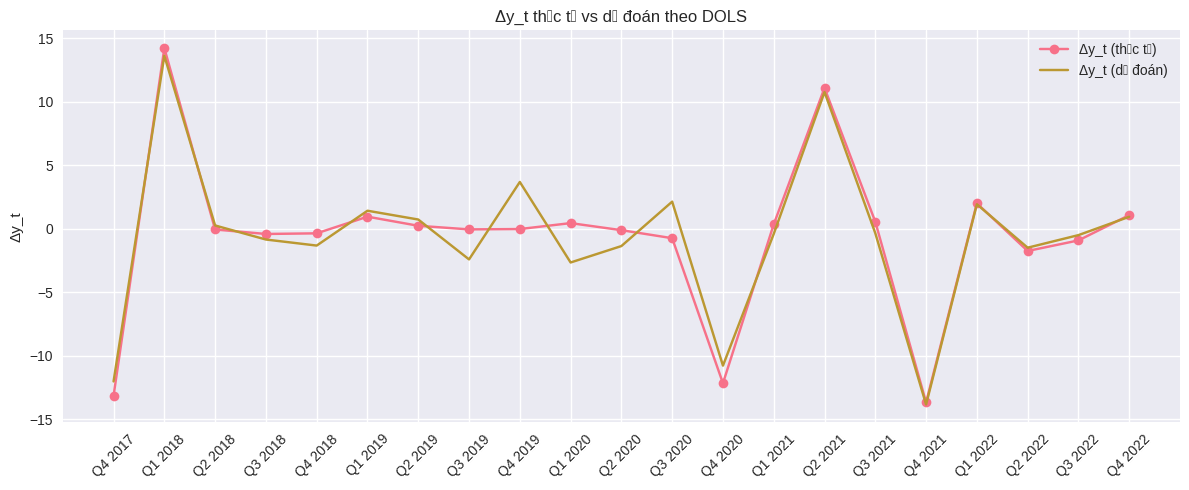


✅ Durbin-Watson: 2.769 → Cần kiểm tra tự tương quan


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
import warnings

warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- 1. Dữ liệu từ Q1 2016 đến Q4 2022 ---
data = {
    'Quarter': [
        'Q1 2016', 'Q2 2016', 'Q3 2016', 'Q4 2016',
        'Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017',
        'Q1 2018', 'Q2 2018', 'Q3 2018', 'Q4 2018',
        'Q1 2019', 'Q2 2019', 'Q3 2019', 'Q4 2019',
        'Q1 2020', 'Q2 2020', 'Q3 2020', 'Q4 2020',
        'Q1 2021', 'Q2 2021', 'Q3 2021', 'Q4 2021',
        'Q1 2022', 'Q2 2022', 'Q3 2022', 'Q4 2022'
    ],
    'Profit': [-302, 170, 41, -2619, 596, 303, 244, -2126, 694, 647, 424, 292,
               749, 937, 881, 852, 1314, 1162, 546, -353, -252, 253, 434, -2007,
               -273, -1593, -4034, -1393],
    'Cost_Income': [84.5, 82.3, 79.8, 86.3, 78.4, 77.8, 80.5, 88.1, 74.1, 74.1, 79.4, 80.2,
                    78.8, 76.2, 77.2, 78.0, 69.4, 70.2, 82.7, 99.0, 52.0, 84.6, 84.1, 135.1,
                    112.2, 130.4, 108.4, 141.6],
    'CET1': [13.6, 14.2, 14.1, 13.5, 12.7, 14.2, 14.0, 13.5, 12.9, 12.8, 12.9, 12.6,
             12.6, 12.5, 12.4, 12.7, 12.1, 12.5, 13.0, 12.9, 12.2, 13.7, 14.4, 14.4,
             13.8, 13.5, 12.6, 14.1]
}

df = pd.DataFrame(data)
df.set_index('Quarter', inplace=True)
print("✅ Dữ liệu đã được tải. Số quan sát:", len(df))


# --- 2. Tạo biến signed log ---
def signed_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)


df['ln_Profit'] = df['Profit'].apply(signed_log)
df['ln_CET1'] = np.log(df['CET1'])
df['ln_Cost_Income'] = np.log(df['Cost_Income'])

# --- 3. Tạo sai phân ---
df['d_ln_Profit'] = df['ln_Profit'].diff()
df['d_ln_CET1'] = df['ln_CET1'].diff()
df['d_ln_Cost_Income'] = df['ln_Cost_Income'].diff()

# --- 4. Biến trễ cho mối quan hệ dài hạn ---
df['ln_CET1_lag1'] = df['ln_CET1'].shift(1)
df['ln_Cost_Income_lag1'] = df['ln_Cost_Income'].shift(1)

# --- 5. Chọn số lượng lag tối ưu (k = 1..3) ---
k_max = 10
results_selection = []

for k in range(1, k_max + 1):
    dynamic_terms = []
    for i in range(1, k + 1):
        df[f'd_ln_CET1_lag{i}'] = df['d_ln_CET1'].shift(i)
        df[f'd_ln_Cost_Income_lag{i}'] = df['d_ln_Cost_Income'].shift(i)
        dynamic_terms.extend([f'd_ln_CET1_lag{i}', f'd_ln_Cost_Income_lag{i}'])

    X_cols = ['ln_CET1_lag1', 'ln_Cost_Income_lag1'] + dynamic_terms
    data_model = df[['d_ln_Profit'] + X_cols].dropna()

    if len(data_model) < 10:
        results_selection.append({'k': k, 'BIC': np.inf, 'AIC': np.inf, 'R2': 0, 'Adj_R2': 0})
        continue

    Y_dols = data_model['d_ln_Profit']
    X_dols = add_constant(data_model[X_cols])
    model = OLS(Y_dols, X_dols).fit()

    results_selection.append({
        'k': k,
        'BIC': model.bic,
        'AIC': model.aic,
        'R2': model.rsquared,
        'Adj_R2': model.rsquared_adj
    })

# --- Chọn k tốt nhất theo BIC ---
result_df = pd.DataFrame(results_selection)
best_k = result_df.loc[result_df['BIC'].idxmin(), 'k']
print("\n✅ Số lag tối ưu theo BIC:", best_k)
print("\n📊 So sánh mô hình với các k khác nhau")
print(result_df[['k', 'R2', 'Adj_R2', 'AIC', 'BIC']].round(3))

# --- 6. Chạy DOLS với k tốt nhất ---
k = 6
dynamic_terms = []
for i in range(1, k + 1):
    df[f'd_ln_CET1_lag{i}'] = df['d_ln_CET1'].shift(i)
    df[f'd_ln_Cost_Income_lag{i}'] = df['d_ln_Cost_Income'].shift(i)
    dynamic_terms.extend([f'd_ln_CET1_lag{i}', f'd_ln_Cost_Income_lag{i}'])

X_cols = ['ln_CET1_lag1', 'ln_Cost_Income_lag1'] + dynamic_terms
data_final = df[['d_ln_Profit'] + X_cols].dropna()
Y_final = data_final['d_ln_Profit']
X_final = add_constant(data_final[X_cols])
model_final = OLS(Y_final, X_final).fit()

print("\n📈 KẾT QUẢ HỒI QUY DOLS")
print(model_final.summary())

# --- 7. Dự đoán Δy_t ---
df_pred = X_final.copy()
df_pred['d_ln_Profit_hat'] = model_final.predict(X_final)
df_result = pd.concat([df['d_ln_Profit'], df_pred['d_ln_Profit_hat']], axis=1).dropna()
df_result.rename(columns={'d_ln_Profit': 'Δy_t (thực tế)', 'd_ln_Profit_hat': 'Δy_t (dự đoán)'}, inplace=True)

print("\n📊 Δy_t thực tế vs dự đoán theo DOLS")
print(df_result.round(4))

# --- 8. Biểu đồ Real vs Predicted ---
plt.figure(figsize=(12, 5))
plt.plot(df_result.index, df_result['Δy_t (thực tế)'], marker='o', label='Δy_t (thực tế)')
plt.plot(df_result.index, df_result['Δy_t (dự đoán)'], marker='x', label='Δy_t (dự đoán)')
plt.title('Δy_t thực tế vs dự đoán theo DOLS')
plt.ylabel('Δy_t')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("dols2.png")
plt.show()

# --- 9. Kiểm tra tự tương quan ---
dw = durbin_watson(model_final.resid)
print(
    f"\n✅ Durbin-Watson: {dw:.3f} → {'Không có tự tương quan rõ rệt' if 1.5 < dw < 2.5 else 'Cần kiểm tra tự tương quan'}")
